## TODO
    1. Train model after unfreezing layers
    2. Train model with large size dataset - to minimize overfitting
    3. Use model trained on Dogs vs Non-Dogs as a base to train the model
    4. Analyze the results and see which images it's misclassifying
    5. Augment from test data and train

## Imports and definitions

In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [26]:
path = "data/"
sz = 224
bs = 64
arch = resnext101_64

## Data Download

In [5]:
!rm -r {path}tmp

In [ ]:
!rm -r {path}*

In [ ]:
!kg download

In [ ]:
!mv *.zip {path}

In [ ]:
files = !ls {path} | grep zip

In [ ]:
for file in files:
    !unzip -qq {path}{file} -d {path}
    !rm {path}{file}

In [ ]:
!mkdir -p {path}weights
!mkdir -p {path}results
!mkdir -p {path}models

## Submission definition

In [27]:
def submit_predictions(learner, is_tta=True):
    if is_tta:
        log_probs,_ = learner.TTA(is_test=True)
        probs = np.exp(log_probs)
        probs = np.mean(probs, axis=0)
    else:
        log_probs = learn.predict(is_test=True)
        probs = np.exp(log_probs)
    probs = np.clip(probs, 0.0001, 0.9999)
    test_fnames = data.test_dl.dataset.fnames
    test_ids = list(map(lambda x: re.split('/|\.',x)[1], test_fnames))
    probs_flattened = probs.flatten()
    probs_formatted = np.array(list(map(lambda x: '%0.6f'%x, probs_flattened)))
    probs_formatted = np.reshape(probs_formatted, probs.shape)
    result = list(map(lambda x: [test_ids[x]] + list(probs_formatted[x]), range(len(test_ids))))
    
    result_file = "./data/results/result.csv"
    header = ','.join(['id']+data.classes)
    np.savetxt(result_file, result, delimiter=',', comments='', fmt='%s', header=header)
    !kg submit {result_file}

## Validation data split

    1. F strings are ruby string interpolation equivalent in python
    2. Suffix .jpg in from csv removes the suffix from files in the train folder
    3. Low bs => low gpu memory usage

In [28]:
def get_data(sz, bs, val_pct=0.15):
    label_csv = f'{path}labels.csv'
    n = len(list(open(label_csv)))-1
    val_idxs = get_cv_idxs(n, val_pct=val_pct)
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path, 'train', label_csv, test_name='test', val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz < 300 else data.resize(300,'tmp')

## Model Training

In [29]:
data = get_data(sz, bs, val_pct=0.15)

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=[0.5, 0.75], xtra_fc=[1024])

### Train with precomputed layers

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 103/136 [00:02<00:00, 37.33it/s, loss=15.5] 


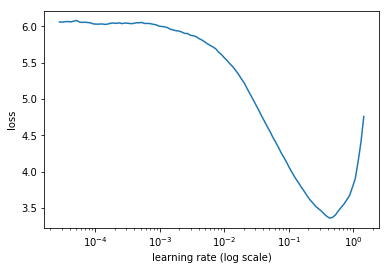

In [31]:
learn.lr_find()
learn.sched.plot()

In [32]:
learn.fit(0.1, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.176427   0.350342   0.91133   
    1      0.845514   0.341768   0.90355                     
    2      0.497579   0.297611   0.92116                     
    3      0.576601   0.329721   0.913998                    
    4      0.409852   0.249115   0.930275                    
    5      0.316336   0.237788   0.92894                     
    6      0.254945   0.314635   0.929004                    



[0.31463465, 0.9290044407049814]

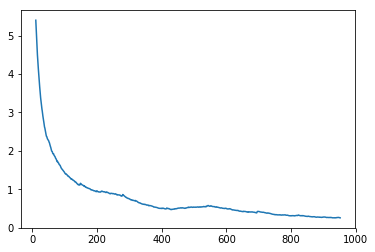

In [33]:
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|███████▋  | 105/136 [00:02<00:00, 37.49it/s, loss=0.306] 


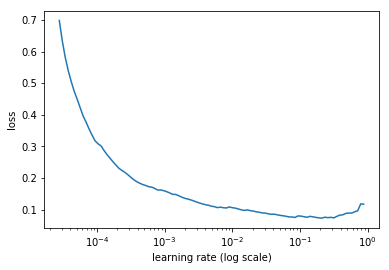

In [20]:
learn.lr_find()
learn.sched.plot()

In [ ]:
submit_predictions(learn)

### Train with data augmentation

In [34]:
learn.precompute = False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 121/136 [01:38<00:12,  1.22it/s, loss=1.64] 

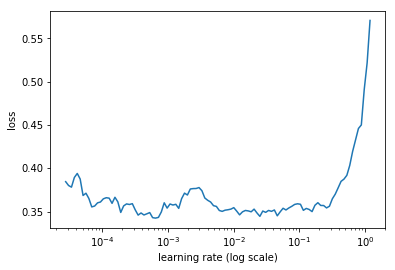

In [35]:
learn.lr_find()
learn.sched.plot()

In [36]:
learn.fit(0.01, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

  0%|          | 0/136 [00:00<?, ?it/s]                     


Exception in thread Thread-55:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.343587   0.210073   0.936817  
    1      0.343457   0.208419   0.935515                    
    2      0.328383   0.205017   0.935515                    
    3      0.323293   0.201055   0.937468                    
    4      0.323688   0.205125   0.934864                    
    5      0.304968   0.205509   0.934864                    
    6      0.285563   0.203644   0.936166                    



[0.20364374, 0.9361658990383148]

In [37]:
submit_predictions(learn)

0.22144                                       


In [34]:
learn.save('224_rexnet101_64_augmented.h5') # Submission - 0.2289

In [39]:
learn.save('224_resnext101_64_xtra_fc_augmented') # Submission - 0.2214

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 120/136 [01:38<00:13,  1.21it/s, loss=1.03] 

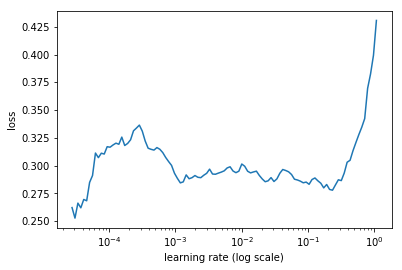

In [42]:
learn.lr_find()
learn.sched.plot()

In [43]:
learn.fit(0.001, 1, cycle_len=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  2%|▏         | 3/136 [00:03<02:33,  1.15s/it, loss=0.205] 


Exception in thread Thread-68:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                    
    0      0.275159   0.205545   0.936817  
    1      0.293069   0.204248   0.933562                    
    2      0.298179   0.204561   0.936166                    



[0.2045607, 0.9361658990383148]

### Learn with dataset change

In [46]:
data299 = get_data(299, bs, val_pct=0.05)
learn.set_data(data299)
learn.freeze()

In [47]:
learn.fit(0.01, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))


epoch      trn_loss   val_loss   accuracy                    
    0      0.341314   0.209924   0.93161   
    1      0.333657   0.202207   0.935516                    
    2      0.291802   0.201938   0.939453                    
    3      0.305915   0.207494   0.93161                     
    4      0.296555   0.208852   0.935516                    
    5      0.299215   0.206169   0.939453                    



[0.20616859, 0.939453125]

In [37]:
learn.save('224_rexnet101_64_augmented_intermediete')

In [15]:
learn.load('224_rexnet101_64_augmented_intermediete')

In [49]:
learn.save('299_rexnet101_64_xtra_fc_1024_augmented')

In [48]:
submit_predictions(learn)

0.20631                                       


In [39]:
learn.fit(0.001, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.253585   0.196218   0.930242  
    1      0.250724   0.196822   0.92894                     
    2      0.239631   0.198411   0.930242                    
    3      0.234837   0.196836   0.927606                    
    4      0.230075   0.195384   0.928908                    
    5      0.252099   0.197359   0.929591                    
    6      0.235193   0.196519   0.926336                    



[0.19651878, 0.9263362362980843]

In [40]:
learn.save('299_resnext101_64_augmented_final')  # Submission 0.212

## Analyze the results

In [46]:
log_preds = learn.predict()

In [52]:
model_results = ImageModelResults(data.val_ds, log_preds)

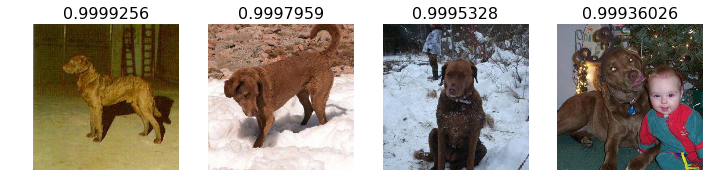

In [73]:
model_results.plot_most_correct(28)

In [74]:
model_results.plot_most_incorrect(28)

False

## Use trained models from Dogs vs Cats as base

## Augment from test data and then train

## Submission